In [1]:
from components import *
import modular_network
import mnist_loader, fashion_mnist_loader
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sci

In [2]:
mnist_train, mnist_val, mnist_test = mnist_loader.load_data_wrapper("../data/mnist.pkl.gz")

In [7]:
n_train = len(mnist_train)
reg = L2Regularization(3.125 / n_train)

net = modular_network.Network([
    Flatten((28, 28)),
    FullyConnected(28*28, 30, tanh(), reg),
    FullyConnected(30, 30, tanh(), reg),
    FullyConnected(30, 10, Softmax(), reg)
], cost=BinaryCrossEntropyCost())

aug = RandUniformAug(-0.2, 0.2)

#optim = SGD_momentum_optimizer(0.005, 20, 0.95)
optim = RMSProp_optimizer(0.005, 20, 0.99)

net.set_optimizer(optim)

In [8]:
net.SGD(mnist_train, 30, 20, mnist_val, data_augmentation = aug,
        monitor_test_acc = True, monitor_training_acc = False)

Epoch 1 training complete, took 1.8987693786621094 seconds
Accuracy on test data: 9196 / 10000
Epoch 2 training complete, took 2.7182557582855225 seconds
Accuracy on test data: 9366 / 10000
Epoch 3 training complete, took 2.567471742630005 seconds
Accuracy on test data: 9459 / 10000
Epoch 4 training complete, took 2.403510808944702 seconds
Accuracy on test data: 9527 / 10000
Epoch 5 training complete, took 2.4640612602233887 seconds
Accuracy on test data: 9550 / 10000
Epoch 6 training complete, took 2.5752363204956055 seconds
Accuracy on test data: 9572 / 10000
Epoch 7 training complete, took 2.485947608947754 seconds
Accuracy on test data: 9601 / 10000
Epoch 8 training complete, took 2.533374547958374 seconds
Accuracy on test data: 9605 / 10000
Epoch 9 training complete, took 2.404578447341919 seconds
Accuracy on test data: 9632 / 10000
Epoch 10 training complete, took 2.8144149780273438 seconds
Accuracy on test data: 9641 / 10000
Epoch 11 training complete, took 2.5085456371307373 se

In [9]:
def backprop_return(net, delta):
    for layer in reversed(net.layers):
        delta = layer.backprop(delta)
    return delta

def get_delta(net, image, Y):
    a_L = net.feedforward(np.array([image]))
    # unscaled delta^L
    delta = net.cost.derivative(a_L, Y)
    # backprop
    return backprop_return(net, delta)[0]


In [10]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))
def relu(x):
    return np.max([x, np.zeros(x.shape)], axis=0)

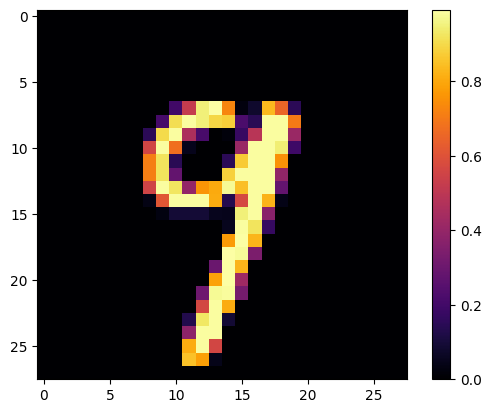

In [102]:
test_image = np.copy(mnist_train[2][0])
plt.imshow(test_image)
plt.colorbar()

In [103]:
net.set_mode(Mode.TEST)

In [104]:
net.feedforward(np.array([test_image]))

array([[1.61184807e-06],
       [5.43691346e-06],
       [4.11562709e-07],
       [1.59795730e-04],
       [7.70725242e-04],
       [9.55737181e-06],
       [1.39889991e-08],
       [1.89804710e-03],
       [5.34673592e-05],
       [9.97100933e-01]])

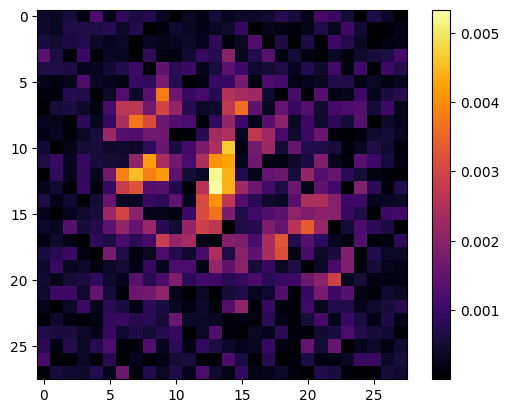

In [114]:
desired_updates = -get_delta(net, test_image, vectorized_result(9))
plt.imshow(np.abs(desired_updates))
plt.colorbar()

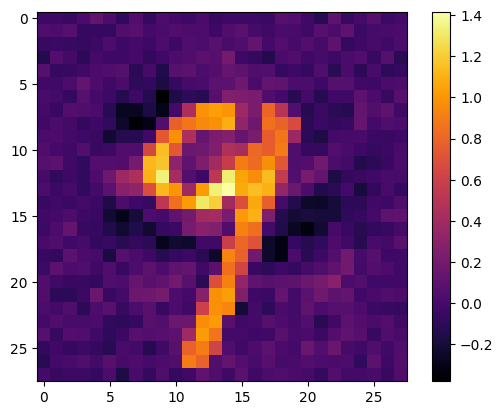

In [124]:
plt.imshow(test_image + 100 * desired_updates)
plt.colorbar()

In [125]:
net.feedforward(np.array([test_image + 100 * desired_updates]))

array([[1.51949640e-07],
       [3.50703170e-06],
       [8.47847821e-08],
       [7.56536054e-05],
       [1.49315651e-04],
       [6.83823445e-06],
       [6.73882298e-09],
       [5.65114790e-06],
       [3.33382336e-04],
       [9.99425409e-01]])

In [19]:
def update_test_image(image, Y, update_rate = 1):
    desired_updates = -get_delta(net, image, Y)
    return image + update_rate * desired_updates

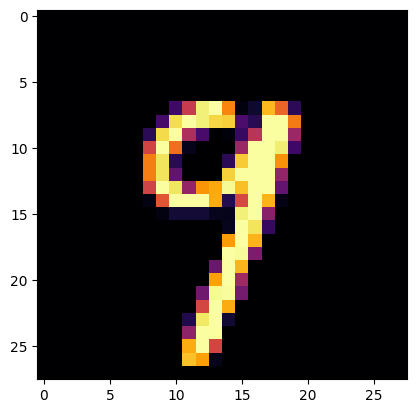

In [70]:
strengthened_image = test_image
plt.imshow(strengthened_image)

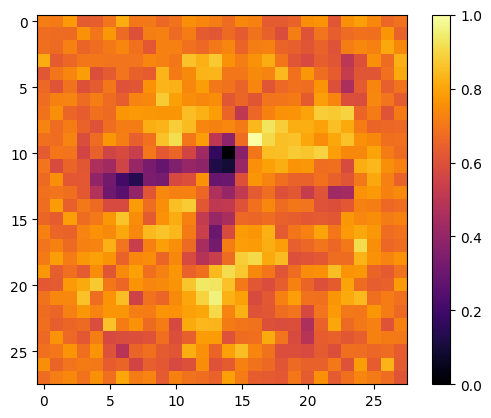

In [71]:
for i in range(1000):
    strengthened_image = update_test_image(strengthened_image, vectorized_result(2))
    strengthened_image = normalize(strengthened_image)
plt.imshow(strengthened_image)
plt.colorbar()

In [72]:
net.feedforward(np.array([strengthened_image]))

array([[1.05878774e-04],
       [3.92873459e-06],
       [9.97847627e-01],
       [1.60778641e-03],
       [8.41566119e-08],
       [3.75760265e-07],
       [4.79071919e-06],
       [1.58060546e-04],
       [2.71391749e-04],
       [7.64295267e-08]])

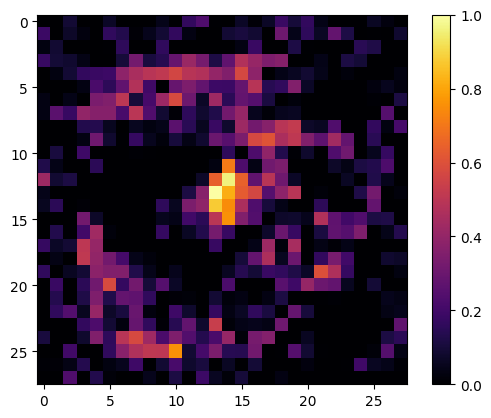

In [101]:
random_image = 0.0 * np.random.uniform(0, 0.2, (28, 28))
dreamed_image = random_image
for i in range(1000):
    dreamed_image = update_test_image(dreamed_image, vectorized_result(3), update_rate = 0.01)
    dreamed_image = relu(dreamed_image)
dreamed_image = normalize(dreamed_image)
plt.set_cmap("inferno")
plt.imshow(dreamed_image)
plt.colorbar()

In [90]:
net.feedforward(np.array([random_image]))

array([[7.83220176e-04],
       [6.43626344e-02],
       [2.91581112e-02],
       [1.22269708e-03],
       [1.18068553e-02],
       [7.02949109e-01],
       [9.58326847e-04],
       [1.55652514e-01],
       [4.99549869e-05],
       [3.30565768e-02]])

In [91]:
net.feedforward(np.array([dreamed_image]))

array([[3.35571515e-06],
       [2.69144125e-07],
       [7.35988232e-06],
       [2.74642584e-03],
       [7.62093654e-08],
       [9.97149302e-01],
       [1.52178026e-05],
       [3.76795996e-09],
       [7.78689706e-05],
       [1.20404112e-07]])

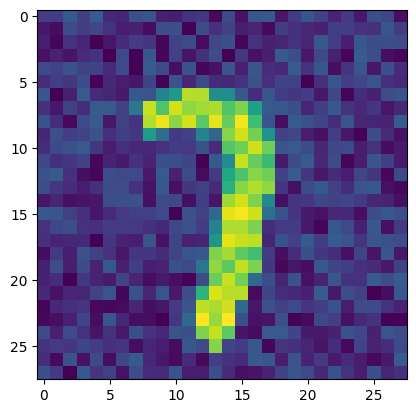

In [62]:
image = mnist_train[3][0]
plt.imshow(aug.fn(image))